In [1]:
import time
%time

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

In [3]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [4]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
## CPU
# device = torch.device("cpu")

## GPU
device = torch.device("cuda:0")

In [6]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model. /home/hdh/PycharmProjects/KoBERT-master/.cache/kobert_v1.zip
using cached model. /home/hdh/PycharmProjects/KoBERT-master/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [7]:
print(vocab)

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")


In [8]:
# # !wget -O /data/ratings_train.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
# # !wget -O /data/ratings_test.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt
# # nsmc(Naver Sentiment Movie Corpus) : 네이버 영화 리뷰 감성 분석
# !wget -O .cache/ratings_train.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
# !wget -O .cache/ratings_test.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt

### GluonNLP Toolkit
* GluonNLP Toolkit provides tools for building efficient data pipelines for NLP tasks.
* https://nlp.gluon.ai/api/modules/data.html#gluonnlp.data.BERTSentenceTransform
* class gluonnlp.data.BERTSPTokenizer(path, vocab, num_best=0, alpha=1.0, lower=True, max_input_chars_per_word=200)[source]¶
* https://nlp.gluon.ai/api/modules/data.html#gluonnlp.data.TSVDataset

In [9]:
dataset_train = nlp.data.TSVDataset(".cache/train_H04W4_220511.txt", field_indices=[0,1], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset(".cache/test_H04W4_220511.txt", field_indices=[0,1], num_discard_samples=1)
# 텍스트 내에 줄바꿈과 탭이 존재하여 오류 발생, 처리 필요

In [10]:
print(dataset_test[:5])

[['본 발명은, 셀룰러 통신 시스템을 이용하여 교통 사고 발생 구간 내의 기지국에 연동되는 휴대 단말에 셀 브로드캐스팅 서비스를 이용하여, 동영상 촬영 요청 메시지를 발신하고, 개별 휴대 단말 사용자로부터 촬영되어 송신된 사고 처리 동영상을 선별하여 저장한 후, 해당 동영상이 링크된 문자 메시지를 사고 발생 구간의 후속 구간에 배치된 기지국(들)에 연동하는 휴대 단말에 발신하여, 원하는 휴대 단말에 사고 처리 동영상을 제공하는, 셀 브로드캐스팅 서비스 및 셀룰러 통신 시스템을 이용한 교통 사고 처리 현황 안내 장치 및 방법을 제공함으로써, 탑승자와의 양방향 정보 제공을 통해 막대한 설치 비용을 수반하는 별도의 동영상 촬상 장치(예컨대, cctv)를 추가하지 않으면서도, 교통 사고 처리 현황에 대한 상세한 동영상을 확보할 수 있으며, 교통 사고 처리 현황에 대해 다양한 각도와 다양한 시야에서 촬영된 동영상을 확보할 수 있다. 이와 같이 확보된 사고 처리 동영상을 사용자가 손쉽게 확인할 수 있도록 함으로써, 교통을 분산시켜 그 소통을 원할하게 할 수 있는 효과가 있다.', '3'], ['차량 통신 서비스를 제공하는 방법 및 장치', '3'], ['생성된 콘텐츠를 BCAST 표준에 맞게 변환하는 단계; 상기 변환된 콘텐츠를 베어러에 맞게 적응시키는 단계; 상기 적응된 콘텐츠를 가입자 단말에 맞게 트랜스코딩하는 단계; 및 상기 트랜스코딩된 콘텐츠를 가입자 단말로 전송하는 단계; 를 포함하는 BCAST 콘텐츠 전송 방법.', '1'], ['적어도 하나의 네트워크 셀(BSC1, BTS1, CELL1; BSC2, BTS2, CELL2, BTS3, CELL3, BTS4, CELL4)을 제어하는 기지국 서브시스템을 포함하는 무선 통신 네트워크(100)에서, 기지국 서브시스템은 무선 블록들을 통하여 상기 셀 내의 이동국들(MS1, MS2, MS3, MS5, MS7)과 통신하고, 상기 기지국 서브시스템에서 데이터 패킷으로 수신된 정보 컨텐츠를 상기 이동국들로 분산시키는 방법에 

### GluonNLP BERTSPTokenizer
* BERTSPTokenizer depends on the sentencepiece library.
* For multi-processing with BERTSPTokenizer, making an extra copy of the BERTSPTokenizer instance is recommended before using it.
* https://nlp.gluon.ai/api/data.html?highlight=bertsptokenizer#gluonnlp.data.BERTSPTokenizer

In [11]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /home/hdh/PycharmProjects/KoBERT-master/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [12]:
print(dataset_train[2][0])

ＷＩＭＡＸ 네트워크 기반의 애드 혹 그룹 방송 서비스 시스템, ＷＩＭＡＸ 네트워크 기반의 애드 혹 그룹 방송 서비스를 위한 애드 혹 그룹 관리자 등록 방법 및 ＷＩＭＡＸ 네트워크 기반의 애드 혹 그룹 방송 서비스 방법


In [13]:
sample_txt = dataset_train[2][0][:256]
# sample_txt = 'GaN 전력 증폭기를 이용한 전력 오실레이터, 본 발명은 GaN(Gallium Nitride) 소자로 구성되며, 입력 신호의 전력을 증폭시켜 출력하는 GaN 전력 증폭기, 상기 GaN 전력 증폭기의 출력 신호의 일부를 피드백 신호로 제공하는 디렉셔널 커플러, 상기 디렉셔널 커플러에 의해서 제공되는 피드백 신호의 페이저를 가변시키는 페이저 시프터 및 상기 페이저 시프터에 의한 임피던스 부정합을 조정하며, 상기 GaN 전력 증폭기로 상기 피드백 신호를 전달하는 제 1 아이솔레이터를 포함하는 GaN 전력 증폭기를 이용한 전력 오실레이터가 제공된다.'
print(tok(sample_txt))

['▁W', 'IM', 'A', 'X', '▁네트워크', '▁기반', '의', '▁애', '드', '▁', '혹', '▁그룹', '▁방송', '▁서비스', '▁시스템', '▁', ',', '▁W', 'IM', 'A', 'X', '▁네트워크', '▁기반', '의', '▁애', '드', '▁', '혹', '▁그룹', '▁방송', '▁서비스를', '▁위한', '▁애', '드', '▁', '혹', '▁그룹', '▁관리', '자', '▁등록', '▁방법', '▁및', '▁W', 'IM', 'A', 'X', '▁네트워크', '▁기반', '의', '▁애', '드', '▁', '혹', '▁그룹', '▁방송', '▁서비스', '▁방법']


In [14]:
print(dataset_train[162][0])

1. 발명의 목적은 음영 지역에서 EV-DO 망을 이용하여 방송 또는 멀티미디어를 수신하는 방법을 제공하기 위한 것이다.2. 발명의 목적은 음영 지역에서 EV-DO 망을 이용하여 방송 또는 멀티미디어를 수신하는 DMB 단말기를 제공하기 위한 것이다.


In [15]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
#         self.labels = [i[label_idx] for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 1000
learning_rate =  5e-5

#### max_len vs batch size
* Text examples should be mostly less than 512 tokens. Longer texts will be cut from the end to fit the sequence length specified in the model block.
* https://peltarion.com/knowledge-center/documentation/cheat-sheets/bert---text-classification-/-cheat-sheet
* Sequence length	Recommended max batch size
    * 64 - 64, 128 - 32, 256 - 16, 320 - 14, 384 - 12, 512 - 6

In [17]:
data_train_id = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test_id = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [18]:
print(data_train_id.sentences[162])

(array([   2,  529,  517,   54, 2235, 6210, 2076, 7086, 3606, 6951, 4329,
       6903,  645,  357,  524,  644,  329, 1968, 7088, 3726, 7815, 2272,
       1862, 2014, 6116, 2872, 6733, 7794, 2270, 7088, 4130, 7789, 3566,
        913,  517,   54,  553,  517,   54, 2235, 6210, 2076, 7086, 3606,
       6951, 4329, 6903,  645,  357,  524,  644,  329, 1968, 7088, 3726,
       7815, 2272, 1862, 2014, 6116, 2872, 6733, 7794,  644,  316,  270,
       1589, 6116, 4130, 7789, 3566,  913,  517,   54,    3,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,  

In [19]:
print(data_train_id.labels[:3])

[0, 1, 0]


* DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, *, prefetch_factor=2, persistent_workers=False)
* https://pytorch.org/docs/stable/data.html
* WARNING
    * After several iterations, the loader worker processes will consume the same amount of CPU memory as the parent process for all Python objects in the parent process which are accessed from the worker processes. This can be problematic if the Dataset contains a lot of data (e.g., you are loading a very large list of filenames at Dataset construction time) and/or you are using a lot of workers (overall memory usage is number of workers * size of parent process). The simplest workaround is to replace Python objects with non-refcounted representations such as Pandas, Numpy or PyArrow objects. Check out issue #13246 for more details on why this occurs and example code for how to workaround these problems.

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train_id, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test_id, batch_size=batch_size, num_workers=5)

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [22]:
model = BERTClassifier(bertmodel, num_classes=5, dr_rate=0.5).to(device)

In [23]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/home/hdh/PycharmProjects/KoBERT-master/venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
# help(nn.CrossEntropyLoss)


In [26]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [27]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [28]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [29]:
print(time.strftime('%l:%M%p %Z on %b %d, %Y')) # ' 1:36PM EDT on Oct 18, 2010'
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
print(time.strftime('%l:%M%p %Z on %b %d, %Y')) # ' 1:36PM EDT on Oct 18, 2010'

 9:14AM KST on May 25, 2022


  0%|          | 0/262 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.5011308193206787 train acc 0.25
epoch 1 train acc 0.4640812431842966


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 test acc 0.6844262295081968


  0%|          | 0/262 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9073958396911621 train acc 0.75
epoch 2 train acc 0.6149809160305344


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 test acc 0.701639344262295


  0%|          | 0/262 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7084909677505493 train acc 0.625
epoch 3 train acc 0.6869547437295529


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 test acc 0.6709016393442623


  0%|          | 0/262 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.2883445918560028 train acc 0.875
epoch 4 train acc 0.7333015267175572


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 test acc 0.7049180327868853


  0%|          | 0/262 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.47231897711753845 train acc 0.75
epoch 5 train acc 0.7666984732824428


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 test acc 0.7172131147540983
 9:22AM KST on May 25, 2022


In [30]:
test_acc = 0.0
results = []
for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    print(batch_id)
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    results.extend(max_indices.tolist())
    test_acc += calc_accuracy(out, label)
    print("test acc {}".format(test_acc / (batch_id+1)))
print(results)
#     print('label: ', label)    

  0%|          | 0/61 [00:00<?, ?it/s]

0
test acc 0.625
1
test acc 0.6875
2
test acc 0.6666666666666666
3
test acc 0.6875
4
test acc 0.725
5
test acc 0.6875
6
test acc 0.6607142857142857
7
test acc 0.671875
8
test acc 0.6805555555555556
9
test acc 0.6875
10
test acc 0.7045454545454546
11
test acc 0.6979166666666666
12
test acc 0.6923076923076923
13
test acc 0.6964285714285714
14
test acc 0.6916666666666667
15
test acc 0.6796875
16
test acc 0.6838235294117647
17
test acc 0.6875
18
test acc 0.6907894736842105
19
test acc 0.70625
20
test acc 0.7083333333333334
21
test acc 0.7159090909090909
22
test acc 0.7119565217391305
23
test acc 0.71875
24
test acc 0.71
25
test acc 0.7115384615384616
26
test acc 0.7083333333333334
27
test acc 0.7053571428571429
28
test acc 0.7155172413793104
29
test acc 0.7166666666666667
30
test acc 0.7137096774193549
31
test acc 0.7109375
32
test acc 0.7159090909090909
33
test acc 0.7205882352941176
34
test acc 0.7178571428571429
35
test acc 0.7118055555555556
36
test acc 0.7195945945945946
37
test acc 0

In [31]:
print(max_indices)
print(max_indices.tolist())


tensor([0, 0, 0, 0, 1], device='cuda:0')
[0, 0, 0, 0, 1]


In [32]:
m = nn.Softmax(dim=1)
exp = m(out)
max_vals, max_indices = torch.max(out, 1)
print(max_indices)

tensor([0, 0, 0, 0, 1], device='cuda:0')


In [36]:
# https://dacon.io/en/competitions/official/235747/codeshare/3082?page=1&dtype=recent
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

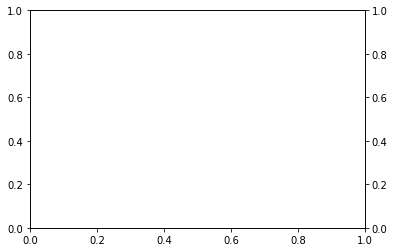

In [39]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(loss.detach().numpy(), 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(train_acc.detach().numpy(), 'b', label='train_acc')
acc_ax.plot(test_acc.detach().numpy(), 'g', label='test_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [35]:
# out = model(token_ids, valid_length, segment_ids)
# print(out)

100%
2344/2344 [10:52<00:00, 3.82it/s]
epoch 1 batch id 1 loss 0.7244999408721924 train acc 0.453125
epoch 1 batch id 201 loss 0.4514557123184204 train acc 0.5766480099502488
epoch 1 batch id 401 loss 0.44362887740135193 train acc 0.6851231296758105
epoch 1 batch id 601 loss 0.5137903094291687 train acc 0.734426996672213
epoch 1 batch id 801 loss 0.43659207224845886 train acc 0.7636352996254682
epoch 1 batch id 1001 loss 0.3066664934158325 train acc 0.7802978271728271
epoch 1 batch id 1201 loss 0.3117211163043976 train acc 0.7930890924229809
epoch 1 batch id 1401 loss 0.30558276176452637 train acc 0.8026075124910778
epoch 1 batch id 1601 loss 0.3304724097251892 train acc 0.8104992973141787
epoch 1 batch id 1801 loss 0.25170841813087463 train acc 0.8164995141588006
epoch 1 batch id 2001 loss 0.2823370695114136 train acc 0.8224481509245377
epoch 1 batch id 2201 loss 0.3238280713558197 train acc 0.8274292935029532
epoch 1 train acc 0.8307713843856656
100%
782/782 [01:06<00:00, 13.16it/s]
epoch 1 test acc 0.8835118286445013
100%
2344/2344 [10:52<00:00, 3.81it/s]
epoch 2 batch id 1 loss 0.4955632984638214 train acc 0.828125
epoch 2 batch id 201 loss 0.2225867211818695 train acc 0.8816075870646766
epoch 2 batch id 401 loss 0.33707231283187866 train acc 0.8836502493765586
epoch 2 batch id 601 loss 0.39554905891418457 train acc 0.887115224625624
epoch 2 batch id 801 loss 0.30988579988479614 train acc 0.8883426966292135
epoch 2 batch id 1001 loss 0.28933045268058777 train acc 0.8911713286713286
epoch 2 batch id 1201 loss 0.24474024772644043 train acc 0.8932269983347211
epoch 2 batch id 1401 loss 0.1908964067697525 train acc 0.8957218058529621
epoch 2 batch id 1601 loss 0.23474052548408508 train acc 0.89772993441599
epoch 2 batch id 1801 loss 0.1599130779504776 train acc 0.8997171710161022
epoch 2 batch id 2001 loss 0.20312610268592834 train acc 0.9019865067466267
epoch 2 batch id 2201 loss 0.2386036366224289 train acc 0.9033251930940481
epoch 2 train acc 0.904759047923777
100%
782/782 [01:06<00:00, 11.77it/s]
epoch 2 test acc 0.8906449808184144
100%
2344/2344 [10:51<00:00, 3.81it/s]
epoch 3 batch id 1 loss 0.3390277922153473 train acc 0.875
epoch 3 batch id 201 loss 0.15983553230762482 train acc 0.9240516169154229
epoch 3 batch id 401 loss 0.14856880903244019 train acc 0.9265118453865336
epoch 3 batch id 601 loss 0.2642267644405365 train acc 0.9280366056572379
epoch 3 batch id 801 loss 0.1951659917831421 train acc 0.93020443196005
epoch 3 batch id 1001 loss 0.26453569531440735 train acc 0.9319586663336663
epoch 3 batch id 1201 loss 0.1282612681388855 train acc 0.9340523522064946
epoch 3 batch id 1401 loss 0.1837957799434662 train acc 0.9360501427551748
epoch 3 batch id 1601 loss 0.14137345552444458 train acc 0.9374414428482198
epoch 3 batch id 1801 loss 0.09849003702402115 train acc 0.9387493059411438
epoch 3 batch id 2001 loss 0.15634101629257202 train acc 0.9401080709645178
epoch 3 batch id 2201 loss 0.1982114464044571 train acc 0.9410495229441163
epoch 3 train acc 0.9420039640216155
100%
782/782 [01:06<00:00, 11.77it/s]
epoch 3 test acc 0.8969988810741688
100%
2344/2344 [10:52<00:00, 3.82it/s]
epoch 4 batch id 1 loss 0.388761043548584 train acc 0.875
epoch 4 batch id 201 loss 0.06205718219280243 train acc 0.9593439054726368
epoch 4 batch id 401 loss 0.06854245811700821 train acc 0.9596711346633416
epoch 4 batch id 601 loss 0.23485814034938812 train acc 0.9600925540765392
epoch 4 batch id 801 loss 0.1342923790216446 train acc 0.9612008426966292
epoch 4 batch id 1001 loss 0.1908232569694519 train acc 0.9621472277722277
epoch 4 batch id 1201 loss 0.11091630905866623 train acc 0.9632597835137385
epoch 4 batch id 1401 loss 0.10650145262479782 train acc 0.9642219842969307
epoch 4 batch id 1601 loss 0.08601253479719162 train acc 0.9649242660836976
epoch 4 batch id 1801 loss 0.057230446487665176 train acc 0.9656093836757357
epoch 4 batch id 2001 loss 0.07411567866802216 train acc 0.9665011244377811
epoch 4 batch id 2201 loss 0.1597125381231308 train acc 0.9671456156292594
epoch 4 train acc 0.9676701151877133
100%
782/782 [01:06<00:00, 11.77it/s]
epoch 4 test acc 0.8980778452685422
100%
2344/2344 [10:52<00:00, 3.81it/s]
epoch 5 batch id 1 loss 0.3727969229221344 train acc 0.890625
epoch 5 batch id 201 loss 0.02794063650071621 train acc 0.9752798507462687
epoch 5 batch id 401 loss 0.024620698764920235 train acc 0.9767378428927681
epoch 5 batch id 601 loss 0.15002880990505219 train acc 0.9765495008319468
epoch 5 batch id 801 loss 0.05448848009109497 train acc 0.9766112671660424
epoch 5 batch id 1001 loss 0.08006531745195389 train acc 0.9770541958041958
epoch 5 batch id 1201 loss 0.04451199620962143 train acc 0.9775317443796836
epoch 5 batch id 1401 loss 0.08561042696237564 train acc 0.9780625446109922
epoch 5 batch id 1601 loss 0.026716381311416626 train acc 0.9783533728919426
epoch 5 batch id 1801 loss 0.02442212402820587 train acc 0.9787357717934481
epoch 5 batch id 2001 loss 0.0197431817650795 train acc 0.9790339205397302
epoch 5 batch id 2201 loss 0.03802771866321564 train acc 0.9792565879145843
epoch 5 train acc 0.9794199729806597
100%
782/782 [01:06<00:00, 11.78it/s]
epoch 5 test acc 0.8974384590792839